###  Imports

In [17]:
from __future__ import print_function
import time
import random
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

###  Results folder and reproducibility

In [ ]:
# Ensure results directory exists
os.makedirs("results", exist_ok=True)

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
np.random.seed(manualSeed)
tf.random.set_seed(manualSeed)

### Hyperparameters and device selection


In [ ]:
num_epochs = 20
batch_size = 32
log_interval = 10
image_size = 64
latent_dim = 32  # z_dim
h_dim = 1024
device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"


### CIFAR-10 dataset loading and preprocessing
- here labels are ignored (_) because the VAE is unsupervised

In [ ]:
(x_train, _), (x_test, _) = cifar10.load_data()
print(x_train.shape, x_test.shape)

### Data transformations
- In data transformations I have resized from 32×32 to 64×64, tensor conversion, and normalization to 
[0,1] to ensure consistent input dimensions and values.

In [ ]:
def preprocess(x):
    # Resize to 64x64
    x = tf.image.resize(x, (image_size, image_size))
    # Scale to [0,1]
    x = tf.cast(x, tf.float32) / 255.0
    return x

train_ds = (tf.data.Dataset.from_tensor_slices(x_train)
            .map(lambda x: preprocess(x), num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(10000)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices(x_test)
          .map(lambda x: preprocess(x), num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))


### VAE model: Sampling layer

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### VAE model: encoder–decoder architecture

In [ ]:
class VAE(Model):
    def __init__(self, image_channels=3, latent_dim=32, h_dim=1024, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.h_dim = h_dim

        # Encoder:
        self.encoder_conv = tf.keras.Sequential([
            layers.Conv2D(32, 4, strides=2, activation="relu", padding="valid"),
            layers.Conv2D(64, 4, strides=2, activation="relu", padding="valid"),
            layers.Conv2D(128, 4, strides=2, activation="relu", padding="valid"),
            layers.Conv2D(256, 4, strides=2, activation="relu", padding="valid"),
            layers.Flatten()
        ])

        # fc1, fc2, fc3 equivalents
        self.fc_mean = layers.Dense(latent_dim)
        self.fc_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()
        self.fc_decode = layers.Dense(h_dim, activation="relu")

        # Decoder: 
        self.decoder_net = tf.keras.Sequential([
            layers.Reshape((1, 1, h_dim)),
            layers.Conv2DTranspose(128, 5, strides=2, activation="relu", padding="valid"),
            layers.Conv2DTranspose(64, 5, strides=2, activation="relu", padding="valid"),
            layers.Conv2DTranspose(32, 6, strides=2, activation="relu", padding="valid"),
            layers.Conv2DTranspose(image_channels, 6, strides=2,
                                   activation="sigmoid", padding="valid"),
        ])

    def encode(self, x):
        h = self.encoder_conv(x)
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

    def decode(self, z):
        h = self.fc_decode(z)
        x_hat = self.decoder_net(h)
        return x_hat

    def call(self, inputs, training=False):
        z_mean, z_log_var, z = self.encode(inputs)
        reconstruction = self.decode(z)
        return reconstruction, z_mean, z_log_var

# Instantiate model and optimizer
with tf.device(device):
    model = VAE(image_channels=3, latent_dim=latent_dim, h_dim=h_dim)

    dummy_input = tf.random.normal((1, image_size, image_size, 3))
    _ = model(dummy_input, training=False)

    print("Full VAE summary:")
    model.summary()

    print("\nEncoder summary:")
    model.encoder_conv.summary()

    print("\nDecoder summary:")
    model.decoder_net.summary()

optimizer = tf.keras.optimizers.Adam(1e-3)

### Loss functions and evaluation metrics (BCE + KL, MSE, SSIM)

In [ ]:
bce_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction="sum")

### VAE loss: reconstruction + KL divergence

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Clamp x to [0,1] similar to F.relu removing negatives
    x_clamped = tf.nn.relu(x)
    recon_clamped = recon_x  # sigmoid output is already in [0,1]

    # Flatten for BCE to roughly mirror reduction='sum' over all pixels
    x_flat = tf.reshape(x_clamped, (tf.shape(x_clamped)[0], -1))
    recon_flat = tf.reshape(recon_clamped, (tf.shape(recon_clamped)[0], -1))
    bce = bce_loss_fn(x_flat, recon_flat)

    # KL divergence
    kld = -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar))
    return bce + kld

### Mean Squared Error (MSE) and Structural Similarity Index Measure (SSIM)

In [ ]:
def compute_mse(x, recon_x):
    x_clamped = tf.nn.relu(x)
    recon_clamped = tf.nn.relu(recon_x)
    return tf.reduce_sum(tf.square(x_clamped - recon_clamped))

def compute_ssim(x, recon_x):
    # Values in [0,1]
    x_clamped = tf.clip_by_value(x, 0.0, 1.0)
    recon_clamped = tf.clip_by_value(recon_x, 0.0, 1.0)
    ssim_per_img = tf.image.ssim(x_clamped, recon_clamped, max_val=1.0)
    ssim_val = tf.reduce_mean(ssim_per_img)
    return 1.0 - ssim_val  


### Training loop for one epoch

In [23]:
def train_one_epoch(epoch):
    train_loss = 0.0
    mse_accum = 0.0
    ssim_accum = 0.0
    num_samples = 0.0

    for batch_idx, x_batch in enumerate(train_ds):
        with tf.GradientTape() as tape:
            recon_batch, mu, logvar = model(x_batch, training=True)
            loss = vae_loss(recon_batch, x_batch, mu, logvar)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        mse = compute_mse(x_batch, recon_batch)
        ssim_value = compute_ssim(x_batch, recon_batch)

        batch_size_actual = tf.cast(tf.shape(x_batch)[0], tf.float32)
        train_loss += loss
        mse_accum += mse
        ssim_accum += ssim_value * batch_size_actual
        num_samples += batch_size_actual

        # ✅ per-batch print removed

    avg_loss = train_loss / num_samples
    avg_mse = mse_accum / num_samples
    avg_ssim = ssim_accum / num_samples

    # ✅ per-epoch print removed (we’ll print in main())
    return avg_loss.numpy(), avg_mse.numpy(), avg_ssim.numpy()


### Evaluation loop for one epoch

In [24]:
def test_one_epoch(epoch):
    test_loss = 0.0
    mse_accum = 0.0
    ssim_accum = 0.0
    num_samples = 0.0

    for i, x_batch in enumerate(val_ds):
        recon_batch, mu, logvar = model(x_batch, training=False)
        loss = vae_loss(recon_batch, x_batch, mu, logvar)

        mse = compute_mse(x_batch, recon_batch)
        ssim_value = compute_ssim(x_batch, recon_batch)

        batch_size_actual = tf.cast(tf.shape(x_batch)[0], tf.float32)
        test_loss += loss
        mse_accum += mse
        ssim_accum += ssim_value * batch_size_actual
        num_samples += batch_size_actual

        if i == 0:
            # Save a grid of original vs reconstructed images (similar to save_image)
            n = min(8, x_batch.shape[0])
            originals = x_batch[:n]
            reconstructions = recon_batch[:n]
            comparison = tf.concat([originals, reconstructions], axis=0).numpy()
            comparison = comparison.reshape(2, n, image_size, image_size, 3)
            top_row = np.hstack(comparison[0])
            bottom_row = np.hstack(comparison[1])
            grid = np.vstack([top_row, bottom_row])
            plt.imsave(f"results/reconstruction_{epoch}.png", grid)

    avg_loss = test_loss / num_samples
    avg_mse = mse_accum / num_samples
    avg_ssim = ssim_accum / num_samples

    # ✅ test print removed (we print in main())
    return avg_loss.numpy(), avg_mse.numpy(), avg_ssim.numpy()


Epoch 1/20 | Train loss: 0.6895  Test loss: 0.6895 | Train MSE: 725.3098  Test MSE: 721.2456 | Train SSIM loss: 0.6827  Test SSIM loss: 0.6795
Epoch 2/20 | Train loss: 0.6892  Test loss: 0.6894 | Train MSE: 723.8373  Test MSE: 720.8892 | Train SSIM loss: 0.6816  Test SSIM loss: 0.6800
Epoch 3/20 | Train loss: 0.6892  Test loss: 0.6894 | Train MSE: 723.8528  Test MSE: 721.1015 | Train SSIM loss: 0.6815  Test SSIM loss: 0.6800
Epoch 4/20 | Train loss: 0.6892  Test loss: 0.6894 | Train MSE: 723.7307  Test MSE: 721.0219 | Train SSIM loss: 0.6815  Test SSIM loss: 0.6800
Epoch 5/20 | Train loss: 0.6892  Test loss: 0.6894 | Train MSE: 723.6448  Test MSE: 721.1091 | Train SSIM loss: 0.6814  Test SSIM loss: 0.6794
Epoch 6/20 | Train loss: 0.6892  Test loss: 0.6894 | Train MSE: 723.6253  Test MSE: 720.8713 | Train SSIM loss: 0.6814  Test SSIM loss: 0.6794
Epoch 7/20 | Train loss: 0.6892  Test loss: 0.6895 | Train MSE: 723.6232  Test MSE: 721.7082 | Train SSIM loss: 0.6813  Test SSIM loss: 0.6796

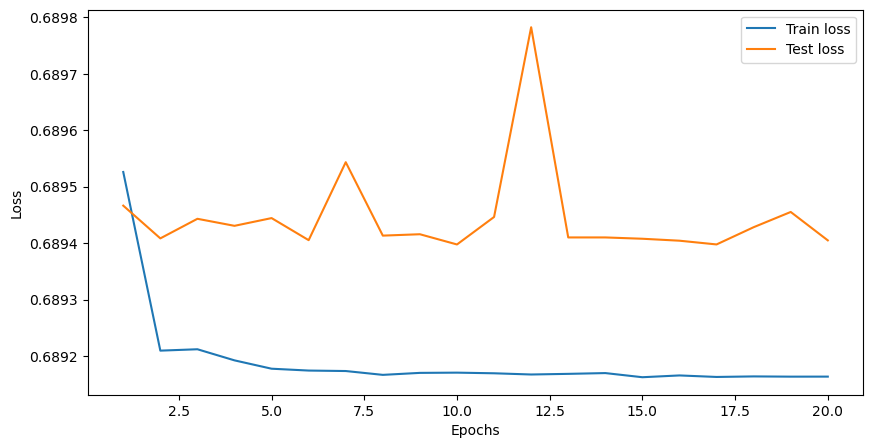

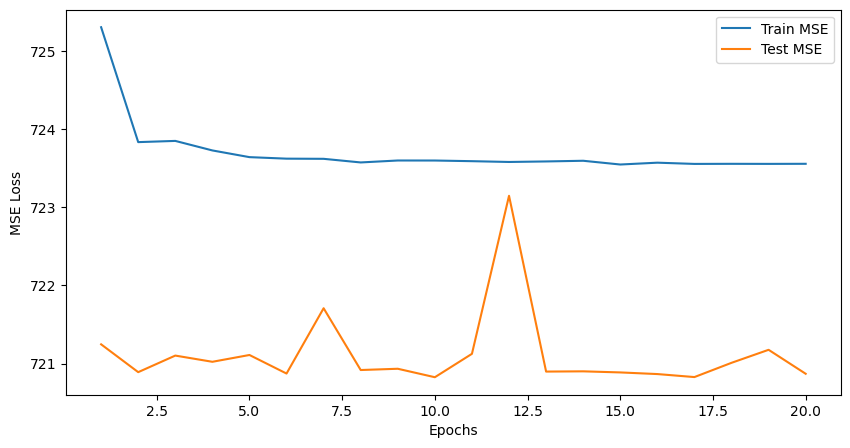

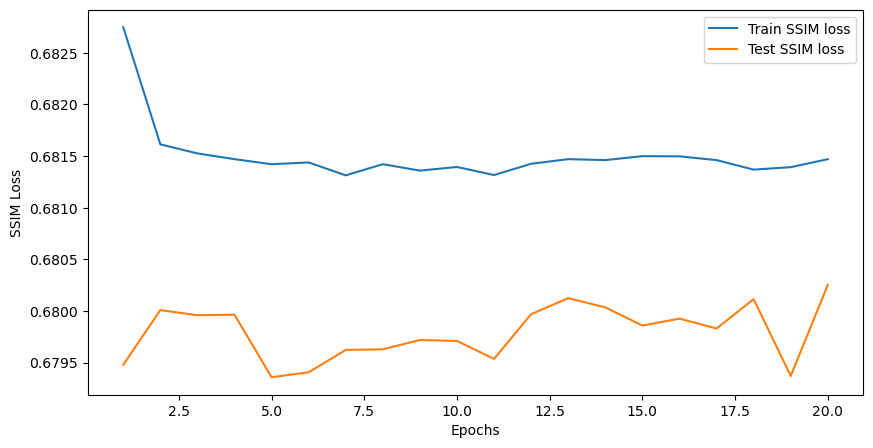

In [25]:
def main():
    train_losses = []
    test_losses = []
    mse_losses = []
    ssim_losses = []
    test_mse_losses = []
    test_ssim_losses = []
    epochs_list = []

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        train_loss, mse_loss_val, ssim_loss_val = train_one_epoch(epoch)
        train_losses.append(train_loss)
        mse_losses.append(mse_loss_val)
        ssim_losses.append(ssim_loss_val)

        test_loss, test_mse, test_ssim = test_one_epoch(epoch)
        test_losses.append(test_loss)
        test_mse_losses.append(test_mse)
        test_ssim_losses.append(test_ssim)
        epochs_list.append(epoch)

        # ✅ NEW: single summary line per epoch
        print(
            f"Epoch {epoch}/{num_epochs} | "
            f"Train loss: {train_loss:.4f}  Test loss: {test_loss:.4f} | "
            f"Train MSE: {mse_loss_val:.4f}  Test MSE: {test_mse:.4f} | "
            f"Train SSIM loss: {ssim_loss_val:.4f}  Test SSIM loss: {test_ssim:.4f}"
        )

        # Sample from the latent space and save a grid (like your sample loop)
        z_samples = tf.random.normal((64, latent_dim))
        samples = model.decode(z_samples).numpy()
        samples = samples.reshape(8, 8, image_size, image_size, 3)
        grid = np.vstack([np.hstack(samples[i]) for i in range(8)])
        plt.imsave(f"results/sample_{epoch}.png", grid)

    end_time = time.time()
    print(f"Training time: {end_time - start_time}s")

    # Plot total loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, train_losses, label="Train loss")
    plt.plot(epochs_list, test_losses, label="Test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot MSE
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, mse_losses, label="Train MSE")
    plt.plot(epochs_list, test_mse_losses, label="Test MSE")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    # Plot SSIM
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_list, ssim_losses, label="Train SSIM loss")
    plt.plot(epochs_list, test_ssim_losses, label="Test SSIM loss")
    plt.xlabel("Epochs")
    plt.ylabel("SSIM Loss")
    plt.legend()
    plt.show()

    # Save model (TensorFlow equivalent of torch.save)
    model.save("vae_cifar10_tf.h5")

if __name__ == "__main__":
    main()
